In [2]:
import numpy as np
import cv2, sys
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal

%matplotlib inline

np.set_printoptions(threshold=sys.maxsize)

In [3]:
img = cv2.imread('images/test.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert the image to grayscale

small = cv2.imread('images/small.png')
small_gray = cv2.cvtColor(small, cv2.COLOR_BGR2GRAY)

bike = cv2.imread('images/bike.png')
bike_gray = cv2.cvtColor(bike, cv2.COLOR_BGR2GRAY)

imsize = 512
noise = np.random.rand(imsize, imsize)*255

Text(0.5, 1.0, 'bike.png')

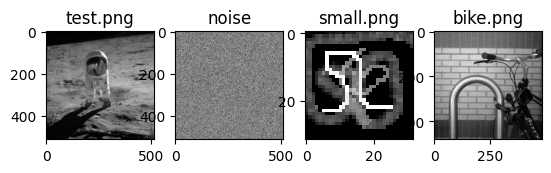

In [4]:
fig, axs = plt.subplots(1, 4)

axs[0].imshow(gray, cmap='gray')
axs[1].imshow(noise, cmap='gray')
axs[2].imshow(small_gray, cmap='gray')
axs[3].imshow(bike_gray, cmap='gray')

axs[0].set_title("test.png")
axs[1].set_title("noise")
axs[2].set_title("small.png")
axs[3].set_title("bike.png")

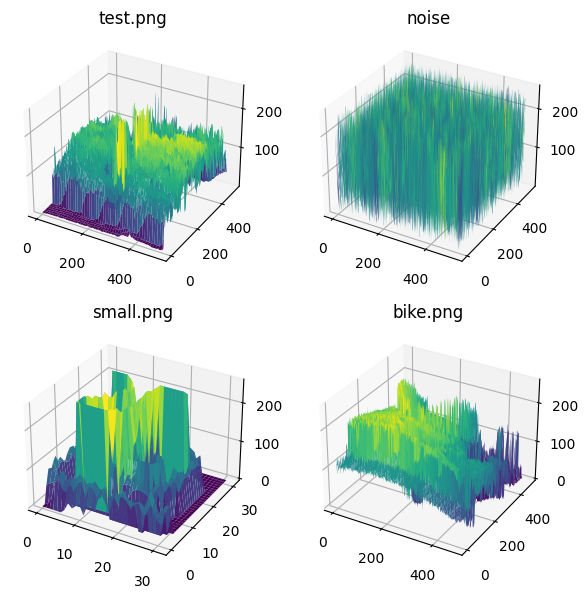

In [5]:
plot_size = 7

heightmap = plt.figure(figsize=(plot_size, plot_size))
plt1 = heightmap.add_subplot(221, projection='3d')
plt2 = heightmap.add_subplot(222, projection='3d')
plt3 = heightmap.add_subplot(223, projection='3d')
plt4 = heightmap.add_subplot(224, projection='3d')

x1 = y1 = range(imsize)
X1, Y1 = np.meshgrid(x1, y1)  # `plot_surface` expects `x` and `y` data to be 2D

x2 = y2 = range(small.shape[0])
X2, Y2 = np.meshgrid(x2, y2)

x3 = y3 = range(bike.shape[0])
X3, Y3 = np.meshgrid(x3, y3)

plt1.plot_surface(X1, Y1, gray, cmap="viridis")
plt2.plot_surface(X1, Y1, noise, cmap="viridis")
plt3.plot_surface(X2, Y2, small_gray, cmap="viridis")
plt4.plot_surface(X3, Y3, bike_gray, cmap="viridis")

plt1.set_title("test.png")
plt2.set_title("noise")
plt3.set_title("small.png")
plt4.set_title("bike.png")

plt.show()

In [6]:
# apply a linear filter to a given neighbourhood
def apply_filter(kernel, image, x, y, mode):

    # set sign needed for kernel access
    if mode == "correlation":
        sign = 1
    elif mode == "convolution":
        sign = -1
    else:
        print("unknown operation")
        sign = 0

    # neighbourhood is of size (2a+1)x(2b+1)
    a = (kernel.shape[0] - 1) // 2
    b = (kernel.shape[1] - 1) // 2
    size = image.shape[0]
    sum = 0
    for i in range(-a, a+1, 1):
        for j in range(-b, b+1, 1):
            value = image[(x+i) % size][(y+j) % size]
            sum += kernel[i * sign][j * sign] * value
    return sum

# filter an entire image
def linear_filter(kernel, image, mode = "correlation"):
    filtered = np.copy(image)
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            filtered[x][y] = apply_filter(kernel, image, x, y, mode)
    return filtered

def root_of_squares(img1, img2):
    assert img1.shape == img2.shape
    combined = np.copy(img1)
    for x in range(combined.shape[0]):
        for y in range(combined.shape[1]):
            combined[x][y] = np.sqrt(img1[x][y]**2 + img2[x][y]**2)
    return combined

In [7]:
n = 3
kernels = {}

# class for allowing iteration over all instances of the Kernel class
class IterRegistry(type):
    def __iter__(cls):
        return iter(cls._registry)

class Kernel(metaclass=IterRegistry):
    _registry = []

    def __init__(self, name, kernel, operation_type="correlation"):
        self._registry.append(self)

        self.name = name
        self.kernel = kernel
        self.operation_type = operation_type

    def __str__(self):
        return self.name

In [8]:
# identity filter
kernelI = np.zeros((n, n))
kernelI[(n-1)//2][(n-1)//2] = 1
identity = Kernel("identity", kernelI)

# primitive smoothing filter
kernel_smooth = 1/(n**2) * np.ones((n, n))
smooth = Kernel("smooth", kernel_smooth)

# left shift
kernel_Rshift = np.zeros((n, n))
kernel_Rshift[(n-1)//2][0] = 1
Rshift = Kernel("Rshift", kernel_Rshift)

# primitive sharpening filter
kernel_sharpen = 2 * kernelI - kernel_smooth
sharpen = Kernel("sharpen", kernel_sharpen)

# gaussian blur
def gaussian_kernel(size=n, sigma=1):
    """Returns a 2D Gaussian kernel array."""
    gaussian_kernel1d = signal.gaussian(size, std=sigma).reshape(size, 1)
    gaussian_kernel2d = np.outer(gaussian_kernel1d, gaussian_kernel1d)
    normalizing_factor = 1/(2*np.pi)
    return gaussian_kernel2d * normalizing_factor

kernel_gaussian = gaussian_kernel(size=n)
gaussian = Kernel("gaussian", kernel_gaussian)

kernel_prewitt_x = np.zeros((3, 3))
kernel_prewitt_x[:,0] = np.ones(3)
kernel_prewitt_x[:,-1] = -np.ones(3)
prewitt_x = Kernel("prewitt_x", kernel_prewitt_x, "convolution")

kernel_prewitt_y = np.zeros((3, 3))
kernel_prewitt_y[0,:] = np.ones(3)
kernel_prewitt_y[-1,:] = -np.ones(3)
prewitt_y = Kernel("prewitt_y", kernel_prewitt_y, "convolution")

for kernel in Kernel:
    kernels[kernel.name] = kernel

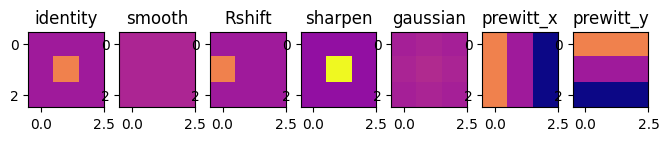

In [9]:
# combine data for all kernels to set a uniform colormap
combined_data = np.array([kernel.kernel for kernel in Kernel])
_min, _max = np.amin(combined_data), np.amax(combined_data)

plot_size = 8
fig, axs = plt.subplots(1, len(kernels), figsize=(plot_size, plot_size))

colormap = "plasma"

i = 0
for key in kernels:
    axs[i].imshow(kernels[key].kernel, vmin = _min, vmax = _max, cmap = colormap)
    axs[i].set_title(key)
    i -=- 1

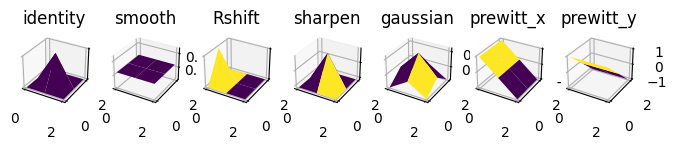

In [10]:
x = y = range(n)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(plot_size, plot_size))

axs = []
i = 0
for key in kernels:
    ax = fig.add_subplot(1, len(kernels), i+1, projection='3d')
    axs.append(ax)
    axs[i].plot_surface(X, Y, kernels[key].kernel, cmap="viridis")
    axs[i].set_title(key)
    i -=- 1
plt.show()

In [11]:
test_image = bike_gray
filtered_images = {}
for key in kernels:
    filtered_images[key] = linear_filter(kernels[key].kernel, test_image, mode=kernels[key].operation_type)

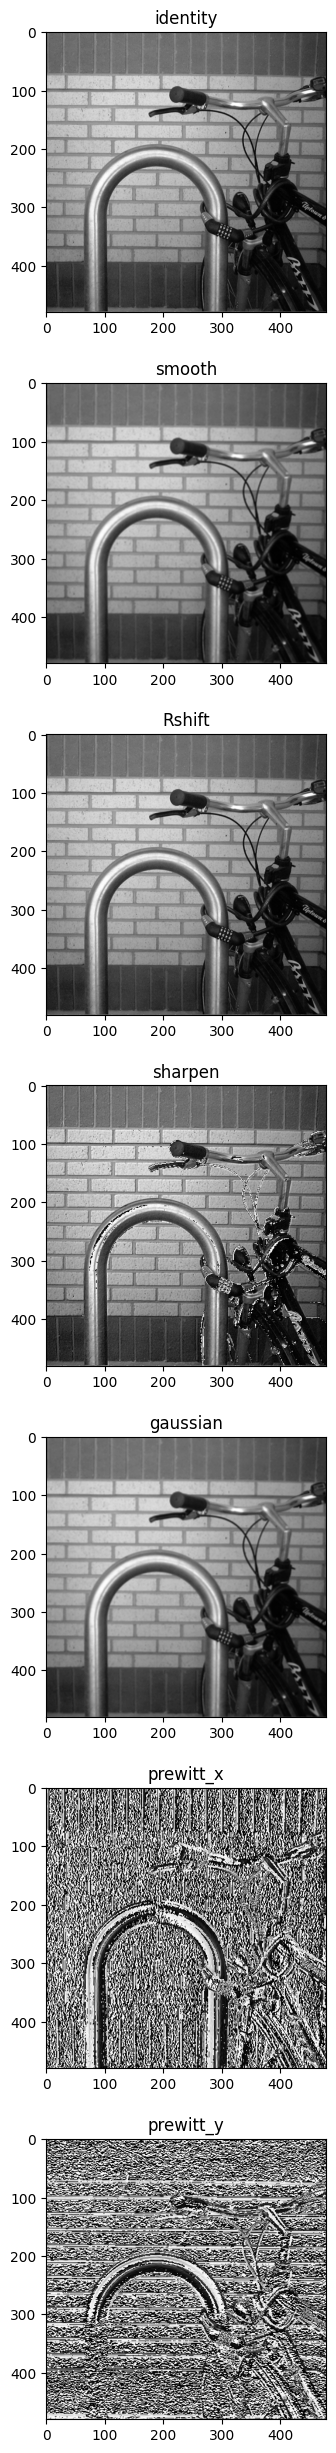

In [12]:
plot_size = 25
padding = 3

fig, axs = plt.subplots(len(kernels), 1, figsize=(plot_size, plot_size))
fig.tight_layout(pad = padding)
i = 0
for key in filtered_images:
    axs[i].imshow(filtered_images[key], cmap='gray')
    axs[i].set_title(key)
    i -=- 1

plt.show()

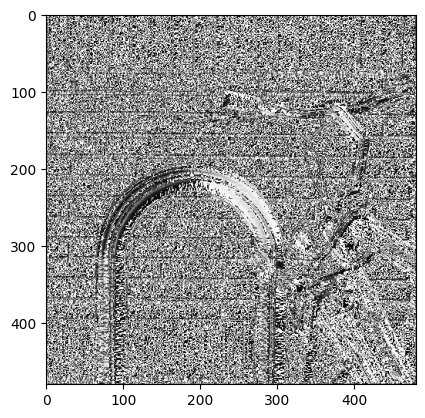

convolution


In [14]:
# fig, axs = plt.subplots(1, 1, figsize=(plot_size, plot_size))
prewitt = root_of_squares(filtered_images["prewitt_x"], filtered_images["prewitt_y"])
plt.imshow(prewitt, cmap='gray')

plt.show()

print(kernels["prewitt_x"].operation_type)